# Find scaling for BFS Data representing in cirlies on a Map

 - BFS grid has a 100m side length --> Radius < ~50m
 - Scaling should work with high-density and low-density regions

## request data form DB 

In [1]:
import sqlite3
import numpy as np

In [2]:
connection = sqlite3.connect('BFS.db')
cursor = connection.cursor()

In [3]:
column_of_interest = 'B08VZAT'
table_of_interest = 'gstatent'

In [4]:
request = cursor.execute("SELECT {} FROM {}".format(column_of_interest, table_of_interest)).fetchall()
cursor.close()
print('number of values: {}'.format(len(request)))
request[:5]

number of values: 1698803


[(3.0,), (3.0,), (3.0,), (3.0,), (3.0,)]

In [5]:
column = np.array([entry[0] for entry in request])
column[:5]

array([3., 3., 3., 3., 3.])

## Plot the data

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 4)
plt.rcParams['figure.dpi'] = 300
plt.style.use('bmh')

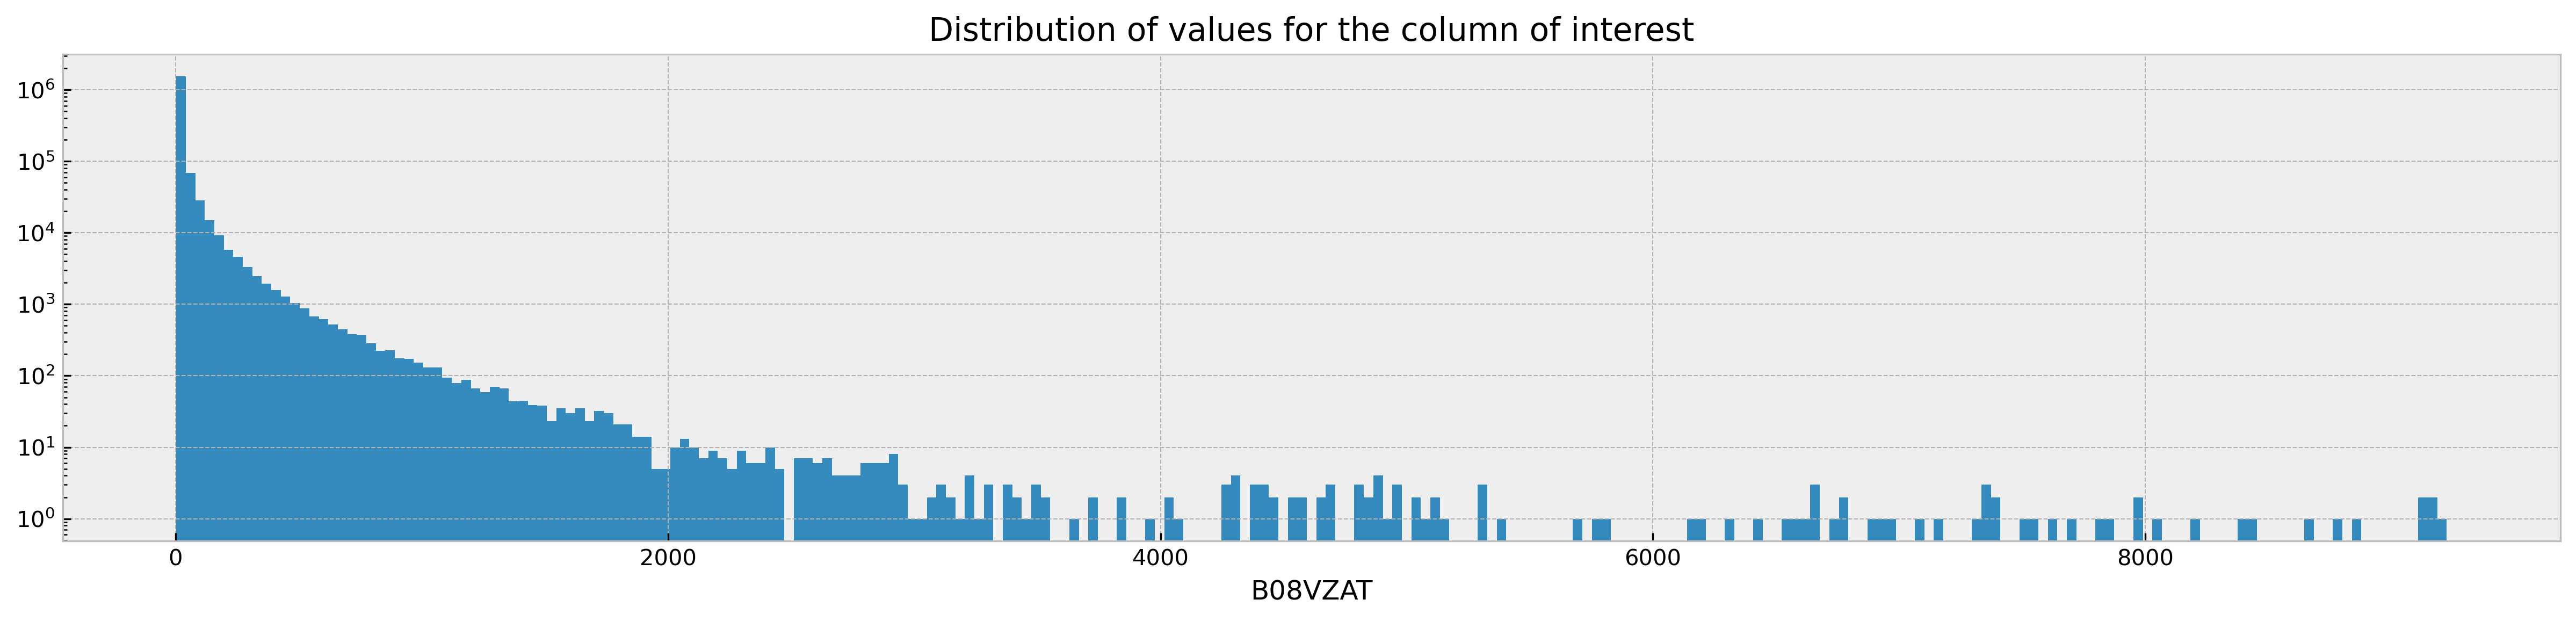

In [7]:
plt.hist(column, bins = 'rice')
plt.xlabel(column_of_interest)
plt.semilogy(), plt.title('Distribution of values for the column of interest');

## Find log function to calculate radius
The logarithm function tries to represent the high dynamics of the data generated above. This data should first be mapped into the correct range. The values must not be less than 1. Furthermore, there must be a scaling factor that can change the slope of the function. After the values have been converted using the logarithm, the values are mapped linearly to the map's required radius.

![visualisacion of log function](https://www.calculat.org/de/logarithmen/obr/log-pl-1.svg)

In [8]:
gradient = 2000

In [9]:
#shift range: starting at 0
minimum = min(column)
column_mapped_1 = column - minimum

#shift range: ending at 1
maximum =  max(column)
column_mapped_2 = column_mapped_1 / maximum 

#change slope: add gradient
column_mapped_3 = column_mapped_2 * gradient

#shift range: starting at 1
column_mapped_4 = column_mapped_3 + 1

# get the Natural logarithm
column_mapped_log = np.log(column_mapped_4)

#shift range: ignor outliers  
quantile =np.quantile(column_mapped_log, 0.999)
column_mapped_log_q = column_mapped_log / quantile

#shift range: apply radius with limits
radius_normalized = 50
radius_min = 2
radius_max = 55
radius = column_mapped_log_q * radius_normalized
radius[radius<radius_min] = radius_min
radius[radius>radius_max] = radius_max

## Plot the result

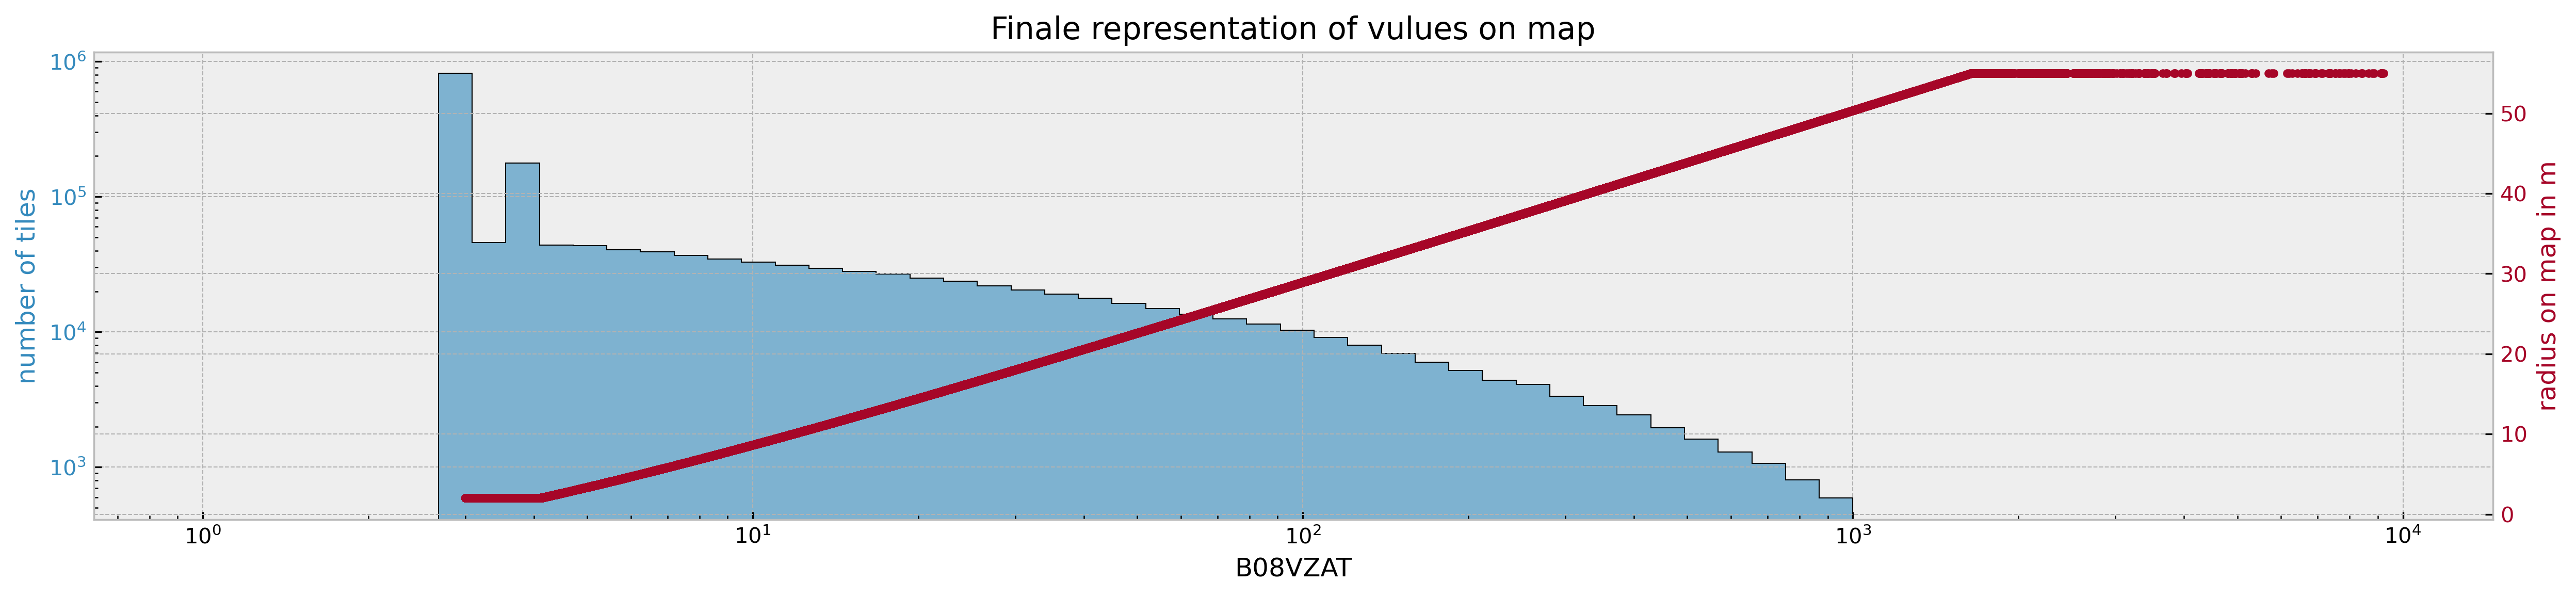

In [10]:
fig, ax1 = plt.subplots()
plt.title('Finale representation of vulues on map')
plt.xlabel(column_of_interest)

plt.hist(column, np.logspace(0,3,50), alpha=0.6, histtype='stepfilled', color = 'C0')
plt.hist(column, np.logspace(0,3,50),  histtype='step', ec='k')
plt.ylabel('number of tiles', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
plt.loglog()

ax2 = ax1.twinx() 
plt.plot(column, radius, '.', color = 'C1')
plt.xlabel(column_of_interest), plt.ylabel('radius on map in m', color = 'C1')
ax2.tick_params(axis='y', labelcolor='C1')
plt.semilogx();

## final function for pipeline example

In [ ]:
row['radius'] = math.log(((float(row[column_of_interest]) - minimum) / maximum * gradient) + 1) / quantile * radius_normalized
row['radius'] = min([row['radius'], radius_max])
row['radius'] = max([row['radius'], radius_min])

In [11]:
column_of_interest, minimum, maximum, gradient, quantile, radius_normalized, radius_max, radius_min 

('B08VZAT', 3.0, 9224.210334399999, 2000, 5.342667579184402, 50, 55, 2)

In [ ]:
#Hard-coded like this
row['radius'] = math.log(((float(row['B08VZAT']) - 3) / 9224 * 2000) + 1) / 5.3 * 50
row['radius'] = min([row['radius'], 55])
row['radius'] = max([row['radius'], 5])